# Osmnx scratchpad

In [269]:
from osmnx import projection, utils_graph, distance
import numpy

from pyproj import CRS
# scipy and sklearn are optional dependencies for faster nearest node search
try:
    from scipy.spatial import cKDTree
except ImportError:
    cKDTree = None
try:
    from sklearn.neighbors import BallTree
except ImportError:
    BallTree = None
EARTH_RADIUS_M = 6_371_009

def is_projected(crs):
    """
    Determine if a coordinate reference system is projected or not.
    This is a convenience wrapper around the pyproj.CRS.is_projected function.
    Parameters
    ----------
    crs : string or pyproj.CRS
        the coordinate reference system
    Returns
    -------
    projected : bool
        True if crs is projected, otherwise False
    """
    return CRS.from_user_input(crs).is_projected

def nearest_k_nodes(G, X, Y, k=1, return_dist=False):
    """
    Find the nearest node(s) to some point(s).
    If the graph is projected, this uses a k-d tree for euclidean nearest
    neighbor search, which requires that scipy is installed as an optional
    dependency. If it is unprojected, this uses a ball tree for haversine
    nearest neighbor search, which requires that scikit-learn is installed as
    an optional dependency.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        graph in which to find nearest nodes
    X : float or numpy.array
        points' x or longitude coordinates, in same CRS/units as graph and
        containing no nulls
    Y : float or numpy.array
        points' y or latitude coordinates, in same CRS/units as graph and
        containing no nulls
    return_dist : bool
        optionally also return distance between points and nearest nodes
    Returns
    -------
    nn or (nn, dist)
        nearest node IDs or optionally a tuple where `dist` contains distances
        between the points and their nearest nodes
    """
    is_scalar = False
    if not (hasattr(X, "__iter__") and hasattr(Y, "__iter__")):
        # make coordinates arrays if user passed non-iterable values
        is_scalar = True
        X = numpy.array([X])
        Y = numpy.array([Y])

    if numpy.isnan(X).any() or numpy.isnan(Y).any():  # pragma: no cover
        raise ValueError("`X` and `Y` cannot contain nulls")
    nodes = utils_graph.graph_to_gdfs(G, edges=False, node_geometry=False)[["x", "y"]]

    if is_projected(G.graph["crs"]):
        # if projected, use k-d tree for euclidean nearest-neighbor search
        if cKDTree is None:  # pragma: no cover
            raise ImportError("scipy must be installed to search a projected graph")
        dist, pos = cKDTree(nodes).query(numpy.array([X, Y]).T, k=k)
        nn = nodes.index[pos]

    else:
        # if unprojected, use ball tree for haversine nearest-neighbor search
        if BallTree is None:  # pragma: no cover
            raise ImportError("scikit-learn must be installed to search an unprojected graph")
        # haversine requires lat, lng coords in radians
        nodes_rad = numpy.deg2rad(nodes[["y", "x"]])
        points_rad = numpy.deg2rad(numpy.array([Y, X]).T)
        [dist], [pos] = BallTree(nodes_rad, metric="haversine").query(points_rad, k=k)
        dist = dist * EARTH_RADIUS_M  # convert radians -> meters
        nn = nodes.index[pos]

    # convert results to correct types for return
    nn = nn.tolist()
    dist = dist.tolist()
    if is_scalar:
        nn = nn[:k]
#         dist = [dist[p] for p in pos]

    if return_dist:
        return nn, dist
    else:
        return nn

In [1]:
import sys

In [160]:
import osmnx as ox
from osmnx import projection

In [3]:
import peartree as pt

### Peartree

In [94]:
path = "data/MBTA_GTFS.zip"
feed = pt.get_representative_feed(path)
start = 7*60*60  # 7:00 AM
end = 10*60*60  # 10:00 AM

In [95]:
PG = pt.load_feed_as_graph(feed, start, end)

In [23]:
from networkx.readwrite import write_gpickle, read_gpickle
# write_gpickle(PG, "feed.pickle")

In [24]:
PG = read_gpickle("feed.pickle")

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

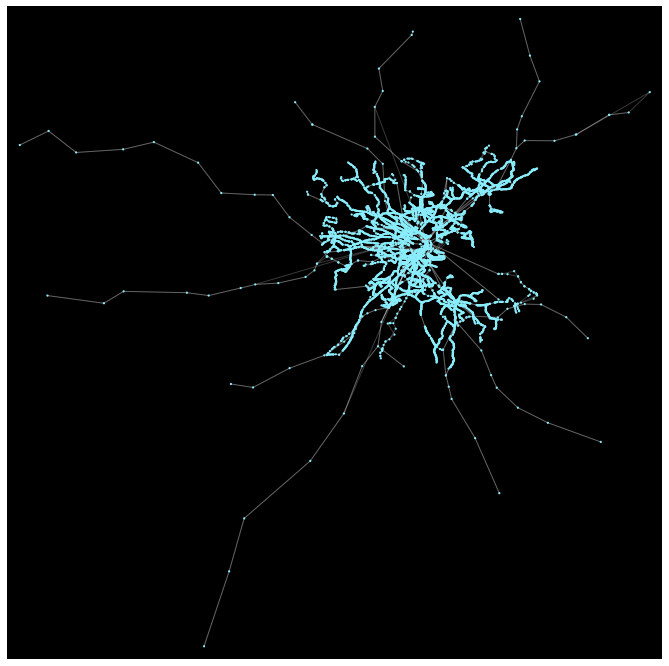

In [141]:
pt.generate_plot(PG, use_agg=True)

### osmnx  
https://github.com/gboeing/osmnx-examples/blob/main/notebooks/01-overview-osmnx.ipynb

<ipython-input-16-dc84f32d059d>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  boston_proj.to_file("./data/boston")


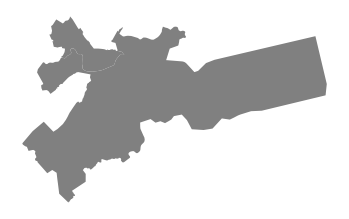

In [16]:
# get the boundary polygon for manhattan, project it, and plot it
places = ["Boston, MA, USA", "Cambridge, MA, USA"]
boston = ox.geocode_to_gdf(places)
boston_proj = ox.project_gdf(city)
boston_proj.to_file("./data/boston")
ax = boston_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [17]:
G = ox.graph_from_place(places, clean_periphery=False, simplify=False)

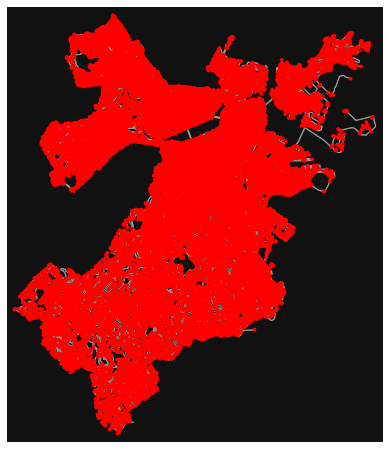

In [19]:
fig, ax = ox.plot_graph(G, node_color="r")

## Route from Harvard to MIT

In [419]:
# Route 1
hrv = (42.37340504571189, -71.118930639685)
mit = (42.36262339607781, -71.08558576037247)

# Route 2
dce = (42.374924557692744, -71.1215097693129)
sse = (42.35206709959629, -71.05520358396896)
bos = (42.36991430142827, -71.02029830382601)

In [250]:
def get_node(graph, point):
    node = ox.distance.get_nearest_node(graph, point)
    return node

In [273]:
(nodes, distances) = nearest_k_nodes(PG, mit[1], mit[0], k=14, return_dist=True)

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [291]:
PG['WKMMO_32549']

AdjacencyView({'WKMMO_2550': {0: {'length': 46.285714285714285, 'mode': 'transit'}}})

In [293]:
PG.nodes.get("WKMMO_32549")

{'boarding_cost': 451.63405673274093,
 'modes': ['3'],
 'y': 42.372535,
 'x': -71.121784}

## Nearest nodes

In [369]:
(nodes, distances) = nearest_k_nodes(PG, dce[0], dce[1], k=3, return_dist=True)
a = nodes

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [370]:
(nodes, distances) = nearest_k_nodes(PG, mit[0], mit[1], k=3, return_dist=True)
b = nodes

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Distances between nearest nodes

In [371]:
from networkx.algorithms.shortest_paths.generic import shortest_path, has_path

In [372]:
PG[a[2]]

AdjacencyView({'WKMMO_PB-0281': {0: {'length': 540.0, 'mode': 'transit'}}})

In [381]:
has_path(PG, a[1], b[0])

True

In [383]:
route = shortest_path(PG, a[1], b[2])

In [384]:
route

['WKMMO_MM-0356-S',
 'WKMMO_MM-0277-S',
 'WKMMO_MM-0219-S',
 'WKMMO_MM-0200',
 'WKMMO_MM-0186',
 'WKMMO_MM-0150-S',
 'WKMMO_MM-0109',
 'WKMMO_PB-0158-S',
 'WKMMO_PB-0194-S',
 'WKMMO_PB-0212-S',
 'WKMMO_PB-0245-S',
 'WKMMO_PB-0281',
 'WKMMO_KB-0351-S']

In [385]:
def get_route_length(graph, route):
    length = 0
    first_node = route[0]
    for node in route[1:]:
        length = length + graph[first_node][node][0]["length"]
        first_node = node
    return length

42.36262339607781

In [386]:
get_route_length(PG, route)

4660.0

In [409]:
def get_shortest_pair(graph, origin, dest, k=3):
    
    nearest_to_a, _ = nearest_k_nodes(graph, origin[1], origin[0], k=k, return_dist=True)
    nearest_to_b, _ = nearest_k_nodes(graph, dest[1], dest[0], k=k, return_dist=True)

    shortest_dist = 1000000000000
    shortest_route = None
    
    for a in nearest_to_a:
        for b in nearest_to_b:
#             print(a, b, "a and b")
            try:
                route = shortest_path(graph, a, b)
#                 print(len(route), "len")
                dist = get_route_length(graph, route)
#                 print(dist, "dist")
                if dist < shortest_dist:
                    shortest_dist = dist
                    shortest_route = route
            except:
                pass
    if shortest_route:
        return (shortest_route, shortest_dist)
    else:
        raise RuntimeError("No shortest path")
                

In [427]:
shortest_route

['WKMMO_70067',
 'WKMMO_70069',
 'WKMMO_70071',
 'WKMMO_70073',
 'WKMMO_70075',
 'WKMMO_70077',
 'WKMMO_70079']

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [429]:
shortest_route

['WKMMO_17095',
 'WKMMO_17096',
 'WKMMO_74614',
 'WKMMO_74615',
 'WKMMO_74616',
 'WKMMO_74617']

In [430]:
import folium

In [437]:
m = folium.Map(location=[45.5236, -122.6750])

In [440]:
(shortest_route, shortest_dist) = get_shortest_pair(PG, hrv, sse, k=5)
ox.folium.plot_route_folium(PG, shortest_route, route_map = m)

(shortest_route, shortest_dist) = get_shortest_pair(PG, bos, sse, k=5)
ox.folium.plot_route_folium(PG, shortest_route, route_map = m)

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initiali

# Playground

In [566]:
from final_project.network5 import Network

In [567]:
pg = Network(PG)

In [568]:
pg.G["WKMMO_1"]["WKMMO_7"]

AtlasView({0: {'length': 120.0, 'mode': 'transit'}})

In [569]:
PG2 = PG.copy()

In [570]:
networkx.convert_matrix.to_pandas_edgelist(pg.G)

,source,target,mode,length
0,WKMMO_1,WKMMO_2,transit,51.692308
1,WKMMO_1,WKMMO_7,transit,120.000000
2,WKMMO_10,WKMMO_56,transit,80.000000
3,WKMMO_10000,WKMMO_8279,transit,60.000000
4,WKMMO_10003,WKMMO_57,transit,65.217391
...,...,...,...,...
7595,WKMMO_6633,WKMMO_6634,transit,0.000000
7596,WKMMO_4393,WKMMO_4394,transit,0.000000
7597,WKMMO_6610,WKMMO_6611,transit,0.000000
7598,WKMMO_6606,WKMMO_16606,transit,0.000000


In [576]:
with pg.open_as_edges_df() as pg_df:
    pg_df["orig_length"] = pg_df["length"]
    pg_df["length"] = pg_df["length"] / 1000 / 4.5 * 60 * 60
    pg_df["mode"] = "walk"

Overwriting 


In [572]:
networkx.convert_matrix.to_pandas_edgelist(pg.G)

,source,target,mode,length,orig_length
0,WKMMO_1,WKMMO_2,walk,41.353846,51.692308
1,WKMMO_1,WKMMO_7,walk,96.000000,120.000000
2,WKMMO_2,WKMMO_6,walk,48.000000,60.000000
3,WKMMO_2,WKMMO_11,walk,96.000000,120.000000
4,WKMMO_2,WKMMO_4,walk,68.571429,85.714286
...,...,...,...,...,...
7595,WKMMO_4390,WKMMO_4391,walk,0.000000,0.000000
7596,WKMMO_6644,WKMMO_6645,walk,0.000000,0.000000
7597,WKMMO_6645,WKMMO_6646,walk,48.000000,60.000000
7598,WKMMO_4329,WKMMO_3355,walk,48.000000,60.000000


In [573]:
PG.nodes

NodeView(('WKMMO_1', 'WKMMO_10', 'WKMMO_10000', 'WKMMO_10003', 'WKMMO_10005', 'WKMMO_10006', 'WKMMO_10007', 'WKMMO_10008', 'WKMMO_10009', 'WKMMO_10010', 'WKMMO_10011', 'WKMMO_10012', 'WKMMO_10013', 'WKMMO_10014', 'WKMMO_10015', 'WKMMO_10016', 'WKMMO_10031', 'WKMMO_10032', 'WKMMO_10033', 'WKMMO_101', 'WKMMO_10100', 'WKMMO_10101', 'WKMMO_102', 'WKMMO_1026', 'WKMMO_1027', 'WKMMO_1029', 'WKMMO_1030', 'WKMMO_1031', 'WKMMO_1032', 'WKMMO_1033', 'WKMMO_1034', 'WKMMO_1035', 'WKMMO_1036', 'WKMMO_1038', 'WKMMO_1039', 'WKMMO_104', 'WKMMO_1040', 'WKMMO_1041', 'WKMMO_10413', 'WKMMO_10417', 'WKMMO_10418', 'WKMMO_10419', 'WKMMO_1042', 'WKMMO_10421', 'WKMMO_10422', 'WKMMO_10423', 'WKMMO_10424', 'WKMMO_10425', 'WKMMO_10427', 'WKMMO_1043', 'WKMMO_1045', 'WKMMO_1046', 'WKMMO_1049', 'WKMMO_1051', 'WKMMO_1052', 'WKMMO_10522', 'WKMMO_1053', 'WKMMO_10540', 'WKMMO_1055', 'WKMMO_1056', 'WKMMO_10569', 'WKMMO_1057', 'WKMMO_1058', 'WKMMO_10582', 'WKMMO_1059', 'WKMMO_10590', 'WKMMO_106', 'WKMMO_1060', 'WKMMO_10603'